# DQN (Deep Q-Network)

#### Autorzy projektu:
* Piotr Kulczycki, 259257
* Sebastian Żółkiewicz, 259337
#### Zajęcia:
*    Algorytmy sztucznej inteligencji w Przemyśle 4.0
#### Grupa:
*    nr 1, poniedziałek, 13:15 - 15:00
#### Prowadzący:
*    Dr inż. Radosław Idzikowski


## Zrealizowane założenia projektu

* Krótki opis problemu
* Samodzielna implementacja Polityki (sieci neuronowej) w c++
* implementacja algorytmu DQN w 4 wariantach
* przeprwoadzenie testów porównawczech zaimplementowanych algorytmów

### Wstęp teoretyczny

**Deep Q-Network (DQN)** to algorytm uczenia maszynowego, który łączy klasyczną metodę Q-learning z głębokimi sieciami neuronowymi, aby rozwiązywać problemy decyzyjne w środowiskach o dużej przestrzeni stanów, jak gry komputerowe (np. Atari). Jest to metoda typu *reinforcement learning* (uczenie ze wzmocnieniem), która pozwala agentowi uczyć się strategii na podstawie doświadczeń zdobywanych podczas interakcji ze środowiskiem.

Algorytm DQN ma na celu znalezienie funkcji wartości Q (Q-value function), która określa oczekiwaną nagrodę (w przyszłości) związaną z podjęciem określonego działania w danym stanie. W klasycznym Q-learningu funkcja wartości Q jest reprezentowana w postaci tablicy, której rozmiar rośnie wykładniczo w zależności od liczby stanów i działań, co jest niewykonalne w przypadku dużych przestrzeni stanów.

DQN rozwiązuje ten problem poprzez zastąpienie tabeli Q funkcją aproksymującą – siecią neuronową. Sieć ta przyjmuje stan jako wejście i zwraca przewidywane wartości Q dla wszystkich możliwych działań w tym stanie.

#### Mechanizm pamięci (Replay Buffer)

Jednym z kluczowych komponentów algorytmu DQN jest **pamięć** (replay buffer), która przechowuje doświadczenia agenta w postaci krotek (stan, akcja, nagroda, nowy stan). W trakcie procesu uczenia agent gromadzi doświadczenia w tej pamięci i losowo je pobiera w celu zaktualizowania parametrów sieci neuronowej. Losowe próbkowanie doświadczeń pozwala na złamanie korelacji między kolejnymi próbkami, co poprawia stabilność procesu uczenia.

Bez tej techniki, dane z kolejnych kroków mogą być silnie powiązane i wprowadzać korelację, co utrudnia proces trenowania sieci neuronowej. **Replay buffer** zwiększa różnorodność danych i zapewnia, że agent uczy się na przykładach z różnych etapów procesu.

#### Mechanizm agenta docelowego (Target Network)

Innym istotnym elementem w DQN jest **mechanizm agenta docelowego**. Zamiast bezpośrednio aktualizować sieć neuronową w oparciu o bieżące wartości Q, DQN używa dwóch kopii sieci neuronowej:
1. **Główna sieć (Q-network)** - jest odpowiedzialna za aktualizację funkcji Q na podstawie doświadczeń, oraz zbieranie doświadczenia poprzez interakcję ze środowiskiem.
2. **Sieć docelowa (Target Network)** - jest kopią głównej sieci, ale jej wagi są aktualizowane rzadziej, co pomaga w stabilizacji procesu uczenia.

Mechanizm target-agenta pozwala na bardziej stabilne uczenie, ponieważ zmiany w funkcji wartości Q nie wpływają na siebie nawzajem w sposób natychmiastowy, co zmniejsza ryzyko niestabilności. Co pewien czas wagi sieci docelowej są kopiowane z głównej sieci, co daje lepszą konwergencję i poprawia wydajność algorytmu.

### Opis implementacji algorytmu

Algorytm uczenia polega na iteracyjnym zbieraniu **jednostek uczących** z otoczenia, oraz uczeniu agenta na ich podstawie.

W projekcie uczenie agenta zostało zawarte w funkcji: **Policy DQN::train(double* learning_time,int* steps_done)**, w której można wyróżnić:

* **for (int i=0 ; i<episode_n ; i++)** - główną pentlę określającą ile powtórzeń pentli uczącej zostanie wykonanych, pętla ta określa rózwnież ile razy gra zostanie zresetowana podczas procesu uczenia

* **while(!done && steps<n_steps_in_one_go)** - pętla odpowiedzialna za wykonanie podstawowych akcji uczenia oraz zbierania informacji o środowisku

* **done = collect_memory_step()** - wykonjue pojedyńczą akcję w środowisku, oraz zapisuje ją do globalnej pamięci

* **learn_from_memory();** - wybiera losową jeden przykład uczący z pamięci i wykonuje na jego podstawie uczenie agenta

wybrane elementy są podstawą rezprezentującą środowisko uczenia ze wzmocnieniem metodą DQN.

Pseudokod wzorcowy stanowiący inspirację do napisania owego algorytmu.


<div>
<img src="pseudo_code.png" width="1000"/>
</div>


W implementacji sugerowano się ospiem działania algorytmu, zawartym na stronie: https://github.com/huggingface/deep-rl-class/blob/main/units/en/unit3/deep-q-algorithm.mdx


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import csv


In [ ]:
def getMeanData(df,h,w):
    filterd_df = (df [(df ['h'] == h) & (df ['w'] == w)])
    mean = filterd_df.mean()
    min = filterd_df.min()
    max = filterd_df.max()
    return (min['time'],mean['time'],max['time']),(min['iterations'],mean['iterations'],max['iterations']) 


In [5]:
sizes = []
# full range of sizes
for h in range(2,10):
   for w in range(2,h+1):
     sizes.append((h,w,h*w))

#dane dla stałej wielkości heigth
# h_const = 9
# for h in range(h_const,h_const+1):
#    for w in range(2,h+1):
#      sizes.append((h,w,h*w))


# for h in range(2,10):
#     sizes.append((h,h,h*h))


sizes = sorted(sizes, key=lambda x: x[2])

In [6]:
df_simple = pd.read_csv("DQN.csv",header=0)
df_memory = pd.read_csv("DQN_memory.csv",header=0)
df_target = pd.read_csv("DQN_target.csv",header=0)
df_full =   pd.read_csv("DQN_memory_target.csv",header=0)

dataFrames = [("simple",df_simple),("memory",df_memory),("target",df_target),("full",df_full)]

dqn_types = [('blue', 'simple'), ('orange', 'memory'), ('green', 'target'), ('red', 'full')]

ready_data_sorted_by_size = {"simple":[],"memory":[],"target":[],"full":[]}

for df_name,df in dataFrames:
  for h,w,_ in sizes:
    ready_data_sorted_by_size[df_name].append((getMeanData(df,h,w),h*w))

print(ready_data_sorted_by_size["simple"])
print(ready_data_sorted_by_size["memory"])
print(ready_data_sorted_by_size["target"])
print(ready_data_sorted_by_size["full"])

[(((0.0116424, 0.496223314, 2.24193), (77.0, 3279.02, 14960.0)), 4), (((0.0281328, 0.920317758, 3.91917), (174.0, 5970.88, 25827.0)), 6), (((0.0287868, 1.20609523, 5.73069), (174.0, 7794.7, 37756.0)), 8), (((0.0368266, 1.505920222, 6.13997), (235.0, 9733.72, 40294.0)), 9), (((0.0336223, 1.6582277539999999, 8.77641), (227.0, 10660.5, 58031.0)), 10), (((0.114056, 2.23415774, 9.22437), (725.0, 14181.32, 59103.0)), 12), (((0.181989, 2.16879436, 7.93954), (1123.0, 13713.52, 51437.0)), 12), (((0.13463, 2.38262576, 8.73489), (812.0, 14823.26, 55839.0)), 14), (((0.108614, 3.30978248, 13.5159), (676.0, 20626.44, 86342.0)), 15), (((0.0789911, 4.622222602, 10.5232), (472.0, 28853.42, 66826.0)), 16), (((0.0862964, 2.5070188279999996, 6.88167), (548.0, 15467.92, 42982.0)), 16), (((0.0652235, 4.50895505, 12.6247), (423.0, 28029.72, 79578.0)), 18), (((0.308638, 3.4901919599999998, 9.89819), (1889.0, 21301.14, 61749.0)), 18), (((0.279327, 6.7356701, 18.8422), (1675.0, 41535.94, 117669.0)), 20), (((0.0

# Prezentacja danych na wykresie 2D

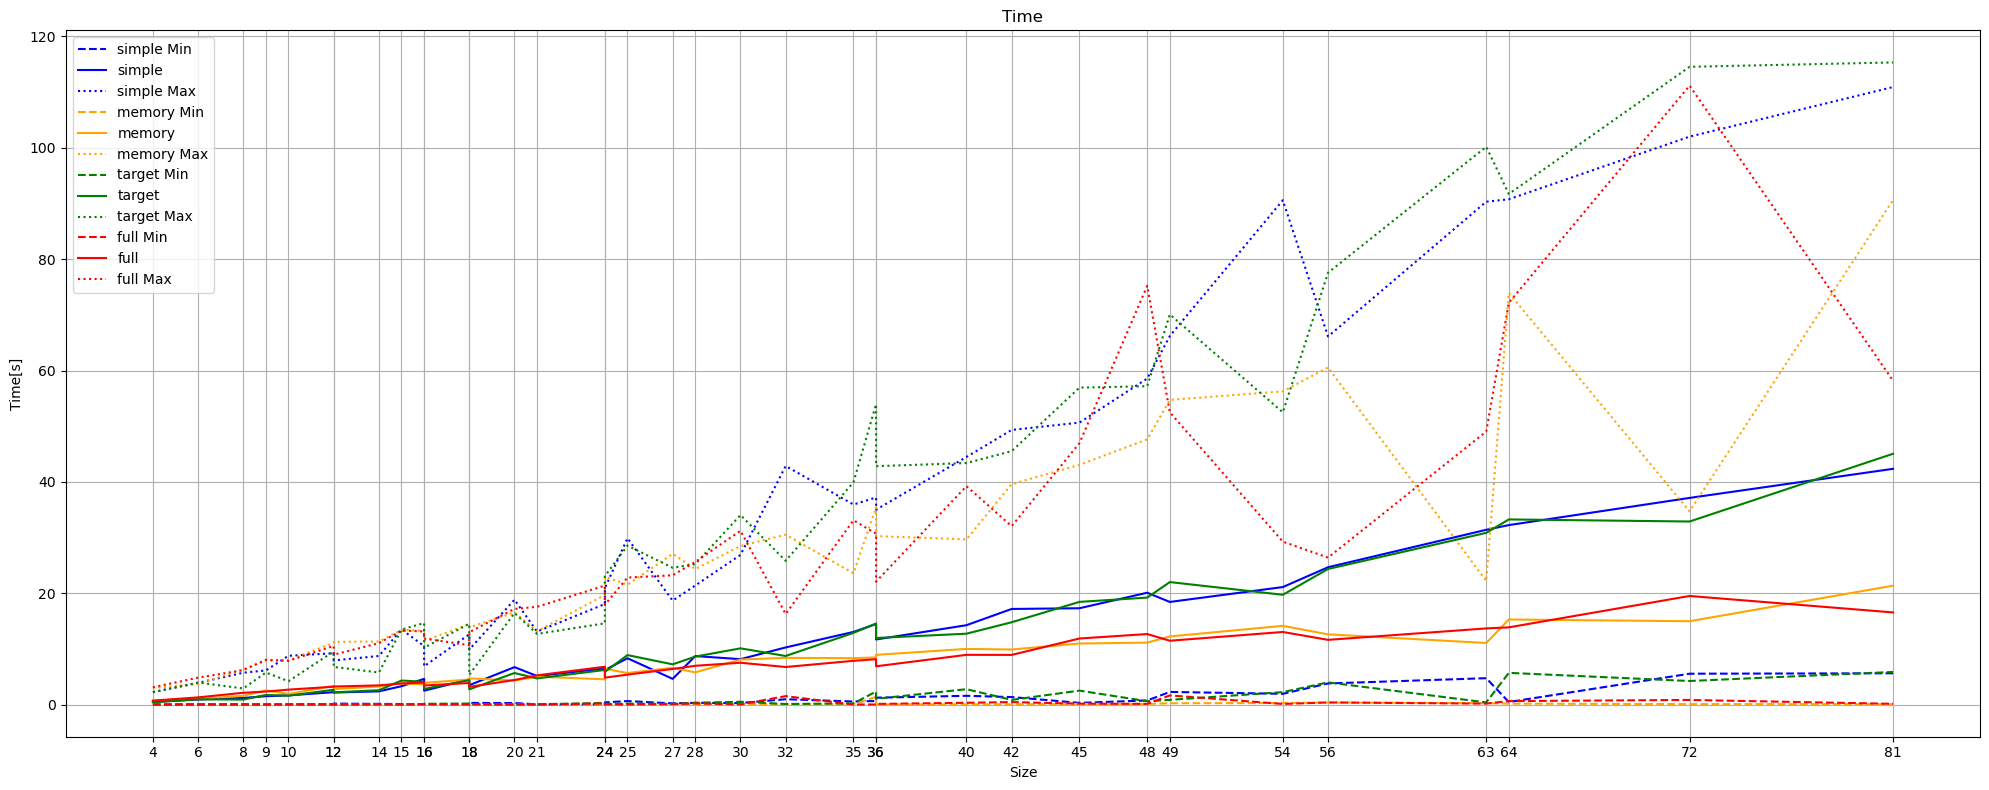

In [7]:
# Time data (min, mean, max)

fig, ax = plt.subplots(figsize=(20, 8))

for color,type in dqn_types:
    time_min = ([x[0][0][0] for x in ready_data_sorted_by_size[type]], [x[1] for x in ready_data_sorted_by_size[type]] )  #uncoment for min value plot
    time_mean = ([x[0][0][1] for x in ready_data_sorted_by_size[type]], [x[1] for x in ready_data_sorted_by_size[type]] ) 
    time_max = ([x[0][0][2] for x in ready_data_sorted_by_size[type]], [x[1] for x in ready_data_sorted_by_size[type]] )  #uncoment for max value plot


    # Plot time data
    ax.plot(time_min[1],time_min[0], label=type + ' Min', color=color, linestyle='--') #uncoment for min value plot
    ax.plot(time_mean[1],time_mean[0], label=type, color=color, linestyle='-')
    ax.plot(time_max[1],time_max[0], label=type + ' Max', color=color, linestyle=':') #uncoment for max value plot


ax.set_xticks(time_mean[1])
ax.set_title('Time')
ax.set_xlabel('Size')
ax.set_ylabel('Time[s]')
ax.legend()

# for i, label in enumerate(labels):
#     ax.text(x_values[i], y_values[i], label, fontsize=9, ha='right', va='bottom')

# Plot iterations data


# Display the plot
plt.grid()
plt.tight_layout()
plt.show()


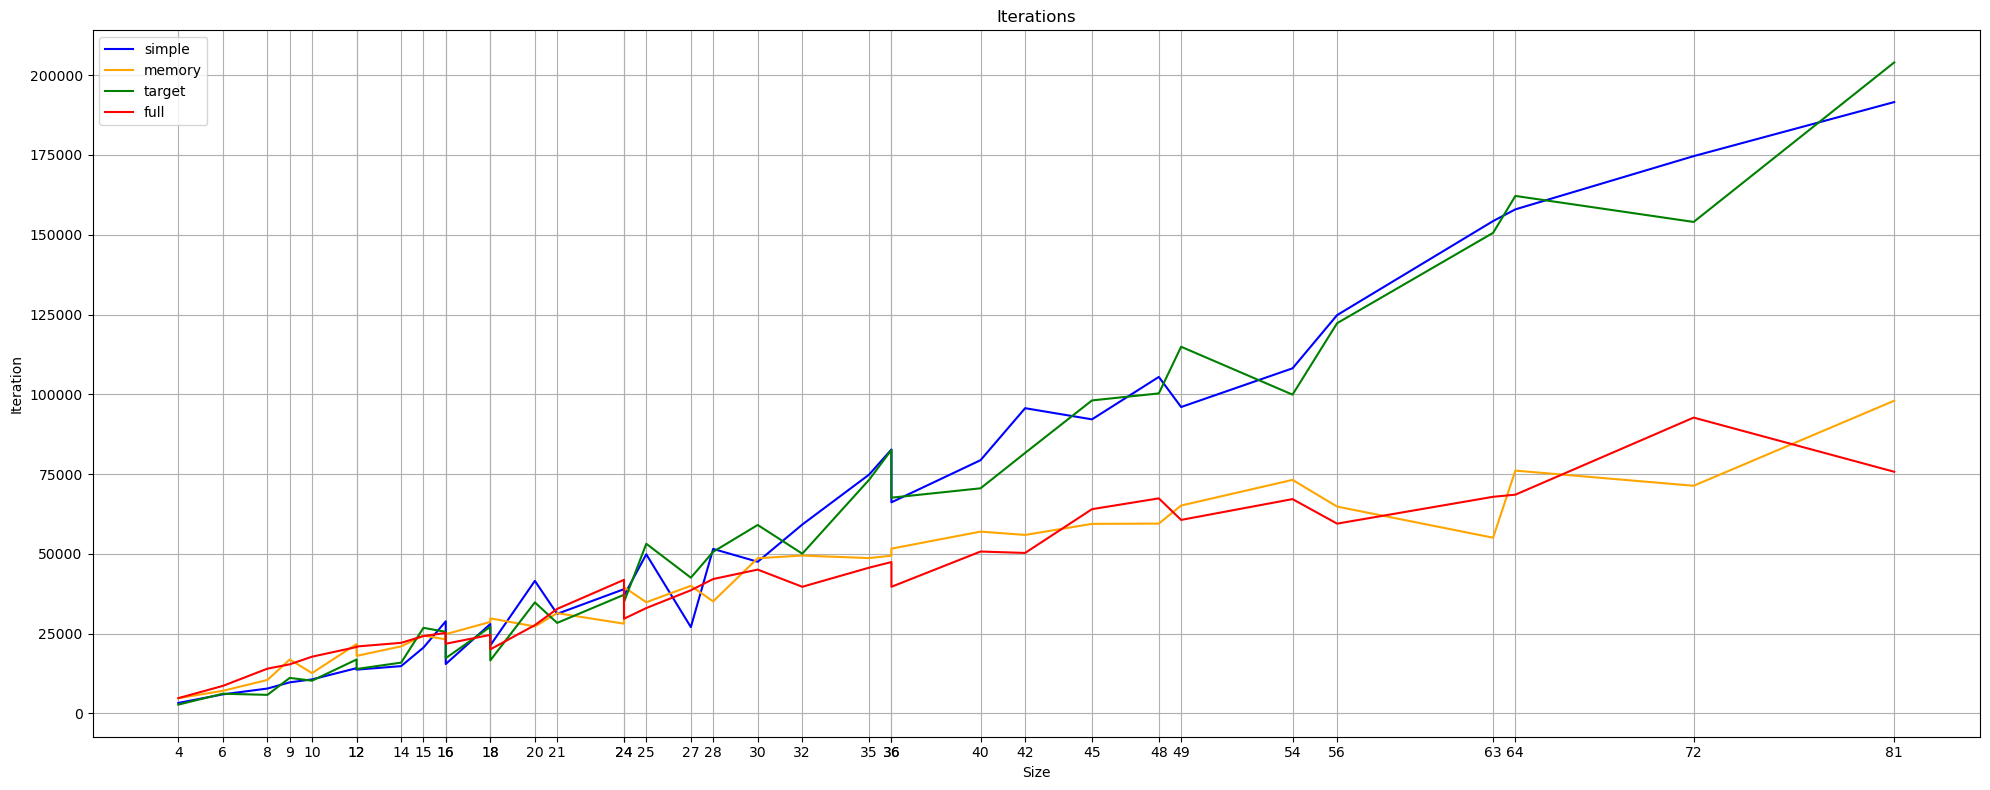

In [13]:
# Iterations data (min, mean, max)
fig, ax = plt.subplots(figsize=(20, 8))

for color,type in dqn_types:
    #time_min = ([x[0][1][0] for x in ready_data_sorted_by_size[type]], [x[1] for x in ready_data_sorted_by_size[type]] )  #uncoment for min value plot
    iter_mean = ([x[0][1][1] for x in ready_data_sorted_by_size[type]], [x[1] for x in ready_data_sorted_by_size[type]] ) 
    #time_max = ([x[0][1][2] for x in ready_data_sorted_by_size[type]], [x[1] for x in ready_data_sorted_by_size[type]] )  #uncoment for max value plot


    # Plot time data
    #ax.plot(time_min[0], label='Time Min', color='blue', linestyle='--') #uncoment for min value plot
    ax.plot(iter_mean[1],iter_mean[0], label=type, color=color, linestyle='-')
    #ax.plot(time_max[0], label='Time Max', color='blue', linestyle=':') #uncoment for max value plot


# for i,label in enumerate(time_mean[1]):
#     ax.text(i, 0, label, fontsize=9, ha='right', va='bottom', color='blue')
ax.set_xticks(iter_mean[1])
ax.set_title('Iterations')
ax.set_xlabel('Size')
ax.set_ylabel('Iteration')
ax.legend()

# for i, label in enumerate(labels):
#     ax.text(x_values[i], y_values[i], label, fontsize=9, ha='right', va='bottom')

# Plot iterations datastanów lub działania).
#plt.xscale('log')
plt.grid()
plt.tight_layout()
plt.show()

# Histogram Danych 

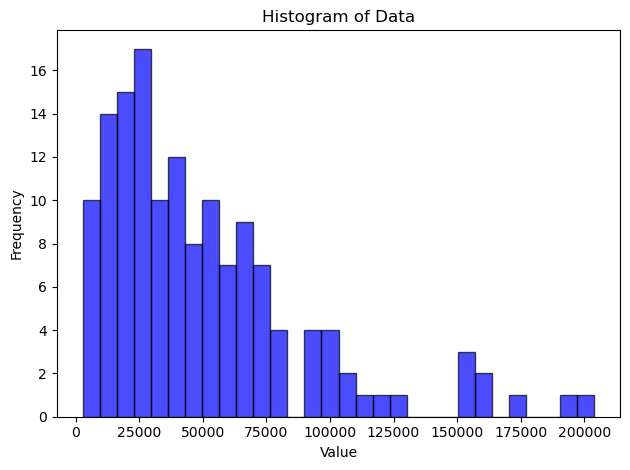

In [11]:
data =[]
for color,type in dqn_types:
    #time_min = ([x[0][1][0] for x in ready_data_sorted_by_size[type]], [x[1] for x in ready_data_sorted_by_size[type]] )  #uncoment for min value plot
    # = ([x[0][1][1] for x in ready_data_sorted_by_size[type]], [x[1] for x in ready_data_sorted_by_size[type]] )
        data += [x[0][1][1] for x in ready_data_sorted_by_size[type]]

plt.hist(data, bins=30, color='blue', edgecolor='black', alpha=0.7)

# Adding labels and title
plt.title('Histogram of Data')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Display the plot
plt.tight_layout()
plt.show()